In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pickle
import nltk
from nltk.corpus import stopwords
import string
import seaborn as sns
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.svm import SVC  # Import SVM
from sklearn.metrics import accuracy_score, precision_score

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\The
[nltk_data]     Printshop\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\The
[nltk_data]     Printshop\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Load the dataset
df = pd.read_csv('fake reviews dataset.csv')
print(df.columns)

Index(['category', 'rating', 'label', 'text_'], dtype='object')


In [4]:
df.drop(columns = {'category'}, inplace = True)
print(df.columns)

Index(['rating', 'label', 'text_'], dtype='object')


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rating  40432 non-null  float64
 1   label   40432 non-null  object 
 2   text_   40432 non-null  object 
dtypes: float64(1), object(2)
memory usage: 947.8+ KB


In [6]:
df.rename(columns = {'text_': 'text'}, inplace = True)
df.head()

,rating,label,text
0,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,5.0,CG,"love it, a great upgrade from the original. I..."
2,5.0,CG,This pillow saved my back. I love the look and...
3,1.0,CG,"Missing information on how to use it, but it i..."
4,5.0,CG,Very nice set. Good quality. We have had the s...


In [7]:
# Function to encode the target labels
def encode_label(df):
    labels = {
        'CG': 1,  # Fake review
        'OR': 0,  # Real review
    }
    df['target'] = df['label'].map(labels)
    return df

In [8]:
# Apply the label encoding
df = encode_label(df)
df['target'] = df['target'].fillna(0).replace([np.inf, -np.inf], 0).astype(int)
df.head()

,rating,label,text,target
0,5.0,CG,"Love this! Well made, sturdy, and very comfor...",1
1,5.0,CG,"love it, a great upgrade from the original. I...",1
2,5.0,CG,This pillow saved my back. I love the look and...,1
3,1.0,CG,"Missing information on how to use it, but it i...",1
4,5.0,CG,Very nice set. Good quality. We have had the s...,1


In [9]:
# Preprocessing: Tokenization, removing stopwords, stemming
ps = PorterStemmer()

In [10]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    # Remove non-alphanumeric characters and apply stemming
    text = [ps.stem(word) for word in text if word.isalnum() and word not in stopwords.words('english')]
    
    return " ".join(text)

df.head()

,rating,label,text,target
0,5.0,CG,"Love this! Well made, sturdy, and very comfor...",1
1,5.0,CG,"love it, a great upgrade from the original. I...",1
2,5.0,CG,This pillow saved my back. I love the look and...,1
3,1.0,CG,"Missing information on how to use it, but it i...",1
4,5.0,CG,Very nice set. Good quality. We have had the s...,1


In [11]:
# Apply text transformation
df['transformed_text'] = df['text'].apply(transform_text)

In [12]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

In [13]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [14]:
# Train an SVM model
svm_model = SVC(kernel='linear')  # You can change the kernel if needed (e.g., 'rbf', 'poly', 'sigmoid')


In [15]:
# Perform cross-validation to get accuracy across multiple splits
kfold = KFold(n_splits=5)  # 5-fold cross-validation

In [16]:
accuracy_scores = []
misclassification_rates = []  # This will act as a proxy for "model loss"

In [17]:
for train_index, test_index in kfold.split(X_train):
    X_train_cv, X_test_cv = X[train_index], X[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]

    # Fit the model on training data for this fold
    svm_model.fit(X_train_cv, y_train_cv)

    # Make predictions on the test fold
    y_pred_cv = svm_model.predict(X_test_cv)
    
    # Calculate accuracy and misclassification
    accuracy = accuracy_score(y_test_cv, y_pred_cv)
    misclassification_rate = 1 - accuracy  # Model loss proxy
    
    accuracy_scores.append(accuracy)
    misclassification_rates.append(misclassification_rate)

In [18]:
# Plot Accuracy and Misclassification Rate
plt.figure(figsize=(10, 5))

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

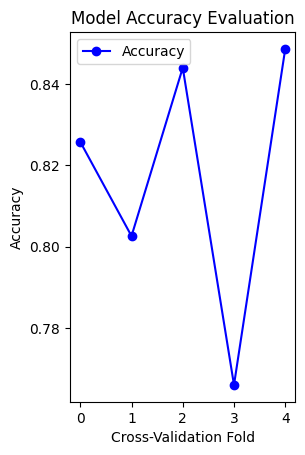

In [19]:
# Plot accuracy line
plt.subplot(1, 2, 1)
plt.plot(accuracy_scores, label='Accuracy', marker='o', color='blue')
plt.title('Model Accuracy Evaluation')
plt.xlabel('Cross-Validation Fold')
plt.ylabel('Accuracy')
plt.legend()

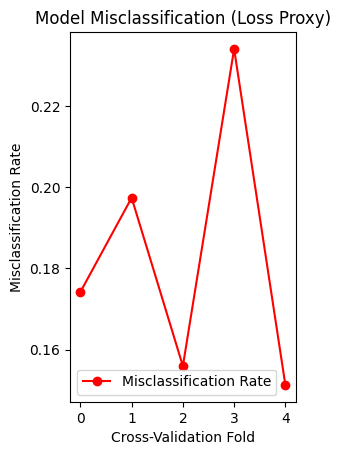

In [20]:
# Plot misclassification line
plt.subplot(1, 2, 2)
plt.plot(misclassification_rates, label='Misclassification Rate', marker='o', color='red')
plt.title('Model Misclassification (Loss Proxy)')
plt.xlabel('Cross-Validation Fold')
plt.ylabel('Misclassification Rate')
plt.legend()

In [21]:
# Show the plots
plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

In [22]:
# Evaluate the model on the actual test set
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')

In [23]:
print(f"Test Set Accuracy: {accuracy}")
print(f"Test Set Precision: {precision}")

Test Set Accuracy: 0.8602695684431804
Test Set Precision: 0.8609510848792831


In [24]:
# Save the trained model and vectorizer
with open('svm_model3.pkl', 'wb') as model_file:
    pickle.dump(svm_model, model_file)

with open('svm_vectorizer3.pkl', 'wb') as vectorizer_file:
    pickle.dump(tfidf, vectorizer_file)

In [25]:
# Evaluate the model
#y_pred = svm_model.predict(X_test)
#accuracy = accuracy_score(y_test, y_pred)
#precision = precision_score(y_test, y_pred, average='weighted')

In [26]:
#print(f"Accuracy: {accuracy}")
#print(f"Precision: {precision}")

In [27]:
# Save the trained model and vectorizer
#with open('svm_model2.pkl', 'wb') as model_file:
    #pickle.dump(svm_model, model_file)

#with open('svm_vectorizer2.pkl', 'wb') as vectorizer_file:
    #pickle.dump(tfidf, vectorizer_file)